In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab.patches import cv2_imshow
import cv2
from sklearn.metrics import auc
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import utils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd '/content/drive/MyDrive/Đồ án CV'

/content/drive/.shortcut-targets-by-id/1-9TYHqR1A3Et3g2S-vc6c0xlzZwaNV2Y/Đồ án CV


In [5]:
class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        mask = Image.open(mask_path)
        mask = np.array(mask)

        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
dataset = PennFudanDataset('PennFudanPed', transforms=None)
img, target = dataset[0]
print("Image shape:", img.size)
print("Target:", target)

Image shape: (559, 536)
Target: {'boxes': tensor([[159., 181., 301., 430.],
        [419., 170., 534., 485.]]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([0]), 'area': tensor([35358., 36225.]), 'iscrowd': tensor([0, 0])}


In [ ]:
def show_predict(model, dataset, image_index):
    image, target = dataset[image_index]
    image = image.unsqueeze(0)

    model.eval()
    with torch.no_grad():
        predictions = model(image)

    boxes = predictions[0]['boxes']
    labels = predictions[0]['labels']
    scores = predictions[0]['scores']
    image_np = image.squeeze(0).permute(1, 2, 0).numpy()
    mask = scores > 0.7

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)

    for box, label, score in zip(boxes[mask], labels[mask], scores[mask]):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        label_text = f"Label: {label}, Score: {score:.2f}"
        ax.text(xmin, ymin, label_text, bbox=dict(facecolor='g', alpha=0.5))

    plt.show()

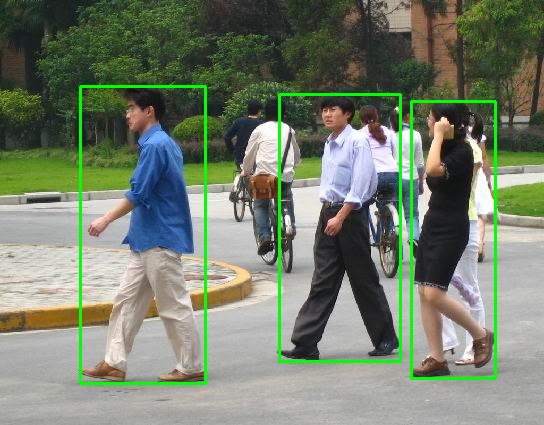

In [ ]:
image_path = "PennFudanPed/PNGImages/FudanPed00016.png"
image = cv2.imread(image_path)

with open('PennFudanPed/Annotation/FudanPed00016.txt', 'r') as f:
    lines = f.readlines()

for line in lines:
    if line.startswith('Bounding box'):
        bbox_coords = line.split(':')[1].strip().replace('(', '').replace(')', '').split('-')
        xmin, ymin = map(int, bbox_coords[0].strip().split(','))
        xmax, ymax = map(int, bbox_coords[1].strip().split(','))

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

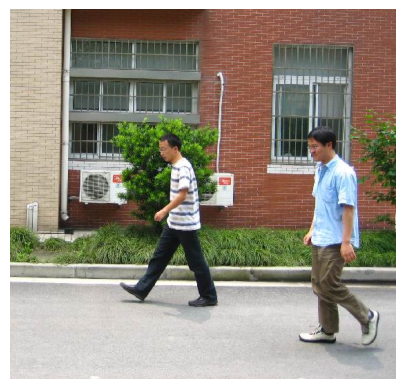

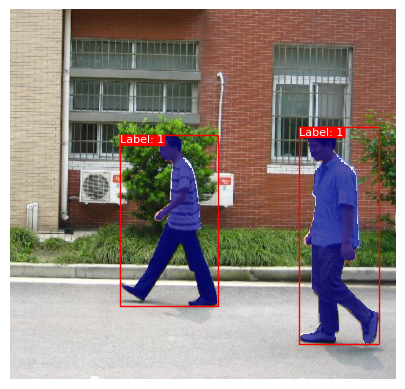

In [ ]:
img, target = dataset[0]

plt.imshow(img)
plt.axis('off')
plt.show()

masks = target['masks']
boxes = target['boxes']
labels = target['labels']
num_objs = len(labels)

fig, ax = plt.subplots(1)
ax.imshow(img)

for i in range(num_objs):
    box = boxes[i]
    mask = masks[i]
    label = labels[i]
    xmin, ymin, xmax, ymax = box
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red')
    ax.add_patch(rect)
    mask = mask.squeeze().numpy()
    mask = np.ma.masked_where(mask == 0, mask)
    plt.imshow(mask, cmap='jet', alpha=0.7)
    plt.text(xmin, ymin, f'Label: {label.item()}', color='white', fontsize=8, verticalalignment='top', bbox={'color': 'red', 'pad': 0})

plt.axis('off')
plt.show()

In [7]:
backbone = torchvision.models.mobilenet_v2().features

backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [8]:
def get_detection_model(num_classes=2):
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    count = 0
    for child in model.backbone.children():
        if count == 0:
            for param in child.parameters():
                param.requires_grad = False
        count += 1

    for param in model.roi_heads.box_head.fc6.parameters():
        param.requires_grad = False

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [9]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [10]:
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch if item[1] is not None]
    return images, targets

In [11]:
ratio = 0.7
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
train_size = int(len(dataset) * ratio)
test_size = len(dataset) - train_size

train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))

Train data size:  118
Test data size:  52


In [12]:
dataloader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_detection_model(num_classes=2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 81.8MB/s]


In [14]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.006,
                            momentum=0.9, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [15]:
all_train_losses = []

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    epoch_loss = 0
    for batch_idx, (images, targets) in enumerate(data_loader):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    all_train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

In [17]:
num_epochs = 30

In [ ]:
print('--------------------------train start--------------------------')
model.to(device)
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq=20)
  lr_scheduler.step()

--------------------------train start--------------------------
Epoch [1/30], Loss: 13.28728087246418
Epoch [2/30], Loss: 9.00484300404787
Epoch [3/30], Loss: 8.03065125644207
Epoch [4/30], Loss: 8.703288182616234
Epoch [5/30], Loss: 7.594702772796154
Epoch [6/30], Loss: 7.992787390947342
Epoch [7/30], Loss: 8.262014478445053
Epoch [8/30], Loss: 7.252540722489357
Epoch [9/30], Loss: 7.794160783290863
Epoch [10/30], Loss: 8.254863411188126
Epoch [11/30], Loss: 7.730025991797447
Epoch [12/30], Loss: 8.369742438197136
Epoch [13/30], Loss: 7.708252169191837
Epoch [14/30], Loss: 8.127722166478634
Epoch [15/30], Loss: 7.8218733966350555
Epoch [16/30], Loss: 8.257153309881687
Epoch [17/30], Loss: 7.8575979843735695
Epoch [18/30], Loss: 8.245564192533493
Epoch [19/30], Loss: 8.201251812279224
Epoch [20/30], Loss: 7.910960279405117
Epoch [21/30], Loss: 7.552172914147377
Epoch [22/30], Loss: 7.388065420091152
Epoch [23/30], Loss: 7.980384163558483
Epoch [24/30], Loss: 7.736459366977215
Epoch [25

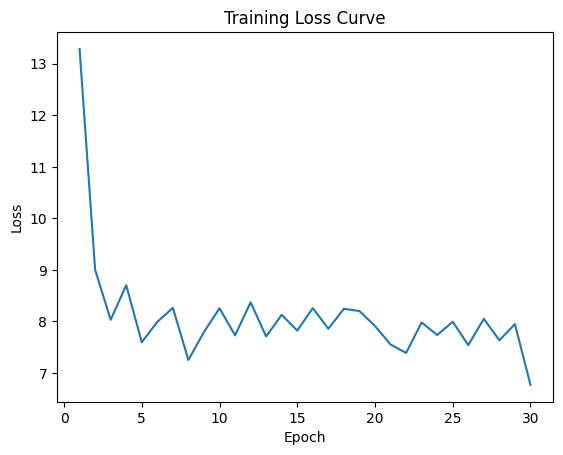

In [ ]:
plt.plot(range(1, num_epochs+1), all_train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}_0006.pt')

In [18]:
model.load_state_dict(torch.load(f'model_{num_epochs}_0006.pt'))

<All keys matched successfully>

In [19]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [20]:
img, _ = test_data[5]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

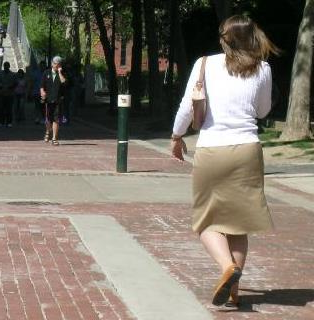

In [21]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

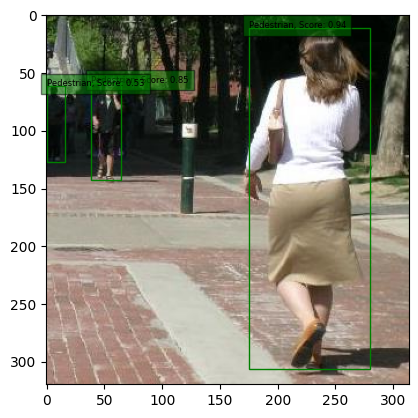

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']
image_np = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().cpu().numpy())

mask = scores > 0.5

fig, ax = plt.subplots(1)
ax.imshow(image_np)
for box, label, score in zip(boxes[mask], labels[mask], scores[mask]):
    xmin, ymin, xmax, ymax = box.cpu().tolist()
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    label_text = f"Pedestrian, Score: {score:.2f}"
    ax.text(xmin, ymin, label_text, bbox=dict(facecolor='g', alpha=0.5), fontsize=6)

plt.show()


In [ ]:
def visualize_prediction(model, image_path):
    model.eval()
    with torch.no_grad():
        image = Image.open(image_path)
        image_tensor = T.ToTensor()(image)

        prediction = model([image_tensor.to(device)])

    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()

    mask = scores > 0.7

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    for box, label, score in zip(boxes[mask], labels[mask], scores[mask]):
        xmin, ymin, xmax, ymax = box.cpu().tolist()
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        label_text = f"Pedestrian, Score: {score:.2f}"
        ax.text(xmin, ymin, label_text, bbox=dict(facecolor='g', alpha=0.5), fontsize=6)

    plt.show()

In [ ]:
image_dir = "Dataset/Test Dataset"
image_files = os.listdir(image_dir)
image_path = os.path.join(image_dir, )


In [ ]:
import os

image_dir = "TestImage"

image_files = os.listdir(image_dir)

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    visualize_prediction(model, image_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def relu(x):
    return max(x, 0)

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    intersection_bbox = np.array([max(dt_bbox[0], gt_bbox[0]),
                                  max(dt_bbox[1], gt_bbox[1]),
                                  min(dt_bbox[2], gt_bbox[2]),
                                  min(dt_bbox[3], gt_bbox[3])])

    intersection_area = relu(intersection_bbox[2] - intersection_bbox[0]) * relu(
        intersection_bbox[3] - intersection_bbox[1])
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou


def evaluate_sample(target_pred, target_true, threshold=0.5):
    gt_bboxes = target_true['boxes'].numpy()
    gt_labels = target_true['labels'].numpy()

    dt_bboxes = target_pred['boxes'].numpy()
    dt_labels = target_pred['labels'].numpy()
    dt_scores = target_pred['scores'].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {'score': dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= threshold:
            detection_result_dict['TP'] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict['TP'] = 0

        results.append(detection_result_dict)

    return results

In [ ]:
def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            targets_true = [{k: v.cpu().float() for k, v in t.items()} for t in targets_true]
            targets_pred = [{k: v.cpu().float() for k, v in t.items()} for t in targets_pred]

            for ii in range(len(targets_true)):
                target_true = targets_true[ii]
                target_pred = targets_pred[ii]
                nbr_boxes += target_true['labels'].shape[0]

                results = results + evaluate_sample(target_pred, target_true)

    results = sorted(results, key=lambda k: k['score'], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]['TP'] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for ii in range(1, len(results)):
        acc_TP[ii] = results[ii]['TP'] + acc_TP[ii - 1]
        acc_FP[ii] = (1 - results[ii]['TP']) + acc_FP[ii - 1]

        precision[ii] = acc_TP[ii] / (acc_TP[ii] + acc_FP[ii])
        recall[ii] = acc_TP[ii] / nbr_boxes

    return recall, precision

In [ ]:
recall, precision = evaluate(model, test_dataloader, device)

In [ ]:
print('mAP:', auc(recall, precision))

mAP: 0.6187420171651975
